# COVID-19 in Australia and Taiwan

## A country comparison

During the ABC's popular "Q and A" on Monday 23 March, it was highlighted by the panelists that Taiwan is doing a much better job than Australia in controlling the spread of COVID-19, despite the almost identical population sizes and Taiwan's higher exposure to visitors to mainland China. This analysis will further investigate this claim and the potential reasons put forward. 

Suggested reasons include:

 - Taiwan's readiness after being scarred by the SARS crisis in 2003
 - Temperature screening of all international visitors at airports, even prior to the COVID-19 outbreak
 - A significantly higher willingness to use data as a tool to track and contain the disease, such as data matching airport arrivals, GP visits and health insurance

In [505]:
# wrangling tools
import numpy as np
import pandas as pd
import datetime as dt
# viz tools
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [304]:
#import sys
#!{sys.executable} -m pip install plotnine

In [283]:
df_c19_all = pd.read_csv('covid_19_data.csv')
df_c19_all.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


This data provides granularity down to the province level, which is useful when looking at countries like China and US. For now though, we are interested in the total confirmed cases per day per country, so we aggregate.

In [445]:
def country_daily(df, country, metric):
    '''
    Creates new data frame for country of choice, aggregated daily
    '''
    df_country_daily = df[df['Country/Region'] == country]
    df_country_daily = df_country_daily[['ObservationDate', metric]].groupby('ObservationDate').sum().reset_index()
    
    return df_country_daily

This analysis will do an comparison of two countries: Australia and Taiwan. We create dataframes for both countries separately, and also merge to make one dataframe for comparison

In [447]:
au_daily = country_daily(df_c19_all, "Australia", "Confirmed")
tw_daily = country_daily(df_c19_all, "Taiwan", "Confirmed")

In [286]:
def merge_countries(df_country1, df_country2, s1, s2):
    
    '''
    Make a merged df of confirmed number in two countries 
    for side-by-side comparison. Include suffixes
    '''
    
    df = pd.merge(df_country1, df_country2, on='ObservationDate', 
                       how='outer', suffixes=['_'+s1, '_'+s2])
    df = df.sort_values('ObservationDate').reset_index(drop=True)
    df = df.fillna(0)

    return(df)

In [310]:
au_tw_daily = merge_countries(au_daily, tw_daily, "au", "tw")
au_tw_daily['ObservationDate'] = pd.to_datetime(au_tw_daily['ObservationDate'])
au_tw_daily

,ObservationDate,Confirmed_au,Confirmed_tw
0,2020-01-22,0.0,1.0
1,2020-01-23,0.0,1.0
2,2020-01-24,0.0,3.0
3,2020-01-25,4.0,3.0
4,2020-01-26,4.0,4.0
...,...,...,...
57,2020-03-19,681.0,108.0
58,2020-03-20,791.0,135.0
59,2020-03-21,1071.0,153.0
60,2020-03-22,1314.0,169.0


Firstly, let's investigate the theory that Australia and Taiwan have had very different rates of increase in confirmed cases of COVID-19 over since late January 2020.

In [408]:
def melt_for_plot(df, melt_var1, melt_var2, melted_val):
    '''
    Takes a dataframe and pivots variables long 
    in preparation for a side-by-side visualisation
    '''
    
    df_long = df[['ObservationDate', melt_var1, melt_var2]].melt('ObservationDate',
                                                      var_name='Country',
                                                      value_name=melted_val).sort_values('ObservationDate')
    df_long.reset_index(drop=True, inplace=True)
    df_long.fillna(0, inplace=True)
    
    country_map = {melt_var1:'Australia', melt_var2:'Taiwan'}
    df_long['Country'] = df_long['Country'].map(country_map)
    
    return(df_long)

In [409]:
au_tw_long = melt_for_plot(au_tw_daily, 'Confirmed_au', 'Confirmed_tw', 'Confirmed')

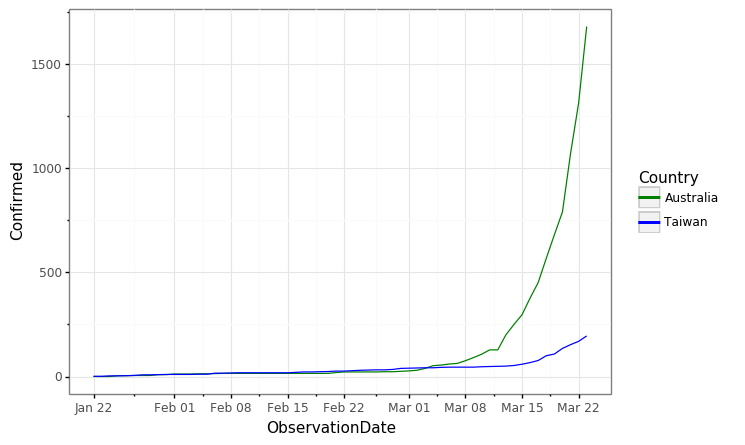

<ggplot: (7019631009)>

In [410]:
p1 = (ggplot(au_tw_long)
 + geoms.geom_line(aes('ObservationDate', 'Confirmed', colour='Country'))
 + p9.scales.scale_colour_manual(values = ("green", "blue"))
 + p9.themes.theme_bw()
 + p9.theme(figure_size=(7,5))
 + p9.scales.scale_x_date(labels = date_format('%b %d'))     
)
p1

It appears the growth rates in confirmed cases for the two countries remained very similar until early March. Lets investigate exactly where growth rates began to differ significantly.

In [389]:
au_tw_daily[['AU_pct_change','TW_pct_change']] = au_tw_daily[['Confirmed_au', 'Confirmed_tw']].pct_change()
au_tw_daily

,ObservationDate,Confirmed_au,Confirmed_tw,AU_pct_change,TW_pct_change
0,2020-01-22,0.0,1.0,NaN,NaN
1,2020-01-23,0.0,1.0,NaN,0.000000
2,2020-01-24,0.0,3.0,NaN,2.000000
3,2020-01-25,4.0,3.0,inf,0.000000
4,2020-01-26,4.0,4.0,0.000000,0.333333
...,...,...,...,...,...
57,2020-03-19,681.0,108.0,0.198944,0.080000
58,2020-03-20,791.0,135.0,0.161527,0.250000
59,2020-03-21,1071.0,153.0,0.353982,0.133333
60,2020-03-22,1314.0,169.0,0.226891,0.104575


In [433]:
pct_change_long = melt_for_plot(au_tw_daily, 
                                'AU_pct_change', 
                                'TW_pct_change', 
                                'Pct_change')
pct_change_long = pct_change_long[pct_change_long['ObservationDate'] > '2020-02-15']

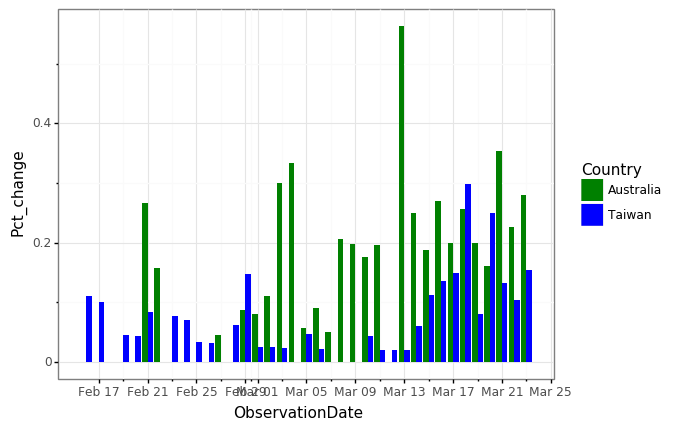

<ggplot: (7026704189)>

In [434]:
(ggplot(pct_change_long, aes('ObservationDate', 'Pct_change', 
                      fill='Country'))
 + geoms.geom_col(stat='identity', position='dodge')
 + p9.scales.scale_fill_manual(values = ("green", "blue"))
 + p9.themes.theme_bw()
 + p9.scales.scale_x_date(labels = date_format('%b %d'))
)

It is clear from the above that Australia has had a much higher daily percentage increase in confirmed cases since Feb15.

At what point did first deaths occur?

In [453]:
au = df_c19[df_c19['Country/Region'] == "Australia"]
tw = df_c19[df_c19['Country/Region'] == "Taiwan"]

In [513]:
au_first_conf = au[au['Confirmed'] == 1.0].sort_values('ObservationDate').head(1)['ObservationDate']
au_first_death = au[au['Deaths'] == 1.0].sort_values('ObservationDate').head(1)['ObservationDate']

tw_first_conf = tw[tw['Confirmed'] == 1.0].sort_values('ObservationDate').head(1)['ObservationDate']
tw_first_death = tw[tw['Deaths'] == 1.0].sort_values('ObservationDate').head(1)['ObservationDate']

In [519]:
print('The first confirmed case in Australia was on {}'.format(au_first_conf.values[0]))
print('The first confirmed death in Australia was on {}'.format(au_first_death.values[0]))
print('\n')
print('The first confirmed case in Taiwan was on {}'.format(tw_first_conf.values[0]))
print('The first confirmed death in Taiwan was on {}'.format(tw_first_death.values[0]))

The first confirmed case in Australia was on 01/27/2020
The first confirmed death in Australia was on 03/01/2020


The first confirmed case in Taiwan was on 01/22/2020
The first confirmed death in Taiwan was on 02/16/2020


In [538]:
def print_dates(df, country, metric):
    country_df = df[df['Country/Region'] == country]
    var = country_df[country_df[metric] == 1.0].sort_values('ObservationDate').head(1)['ObservationDate']
    var = var.values[0]
    return(var)

In [548]:
inputs = {'Australia':'Confirmed', 'Australia':'Deaths',
         'Taiwan':'Confirmed','Taiwan':'Deaths'}

for key, value in inputs.items():
    print(key,value)

Australia Deaths
Taiwan Deaths


In [476]:
# Fist Aus death
au[au['Confirmed'] == 1.0].sort_values('ObservationDate').head(1)['ObservationDate']

266    01/27/2020
Name: ObservationDate, dtype: object

In [458]:
tw[tw['Deaths'] == 1.0].sort_values('ObservationDate').head(1)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
1601,1602,02/16/2020,Taiwan,Taiwan,2020-02-16T11:23:06,20.0,1.0,2.0
